In [1]:
import datetime
print(f"Notebook last updated: {datetime.datetime.now()}")

Notebook last updated: 2024-10-09 09:52:25.428863


In [2]:
import torch
import torchvision

model = torchvision.models.resnet50() 

In [3]:
model = torchvision.models.resnet50() # note: this could be any model
compiled_model = torch.compile(model) 

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2 # <- use the latest weights (could also use .DEFAULT)
transforms = model_weights.transforms()

# Setup model
model = torchvision.models.resnet50(weights=model_weights)

# Count the number of parameters in the model 
total_params = sum(
    param.numel() for param in model.parameters() # <- all params
	# param.numel() for param in model.parameters() if param.requires_grad # <- only trainable params
)

print(f"Total parameters of model: {total_params} (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)")
print(f"Model transforms:\n{transforms}")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s] 


Total parameters of model: 25557032 (the more parameters, the more GPU memory the model will use, the more *relative* of a speedup you'll get)
Model transforms:
ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [6]:
def create_model(num_classes=10):
  """
  Creates a ResNet50 model with the latest weights and transforms via torchvision.
  """
  model_weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
  transforms = model_weights.transforms()
  model = torchvision.models.resnet50(weights=model_weights)
  
  # Adjust the number of output features in model to match the number of classes in the dataset
  model.fc = torch.nn.Linear(in_features=2048, 
                             out_features=num_classes)
  return model, transforms

model, transforms = create_model()

In [7]:
BATCH_SIZE = 32
# IMAGE_SIZE = 128

In [8]:
# transforms.crop_size = IMAGE_SIZE
# transforms.resize_size = IMAGE_SIZE 
# print(f"Updated data transforms:\n{transforms}")


In [9]:
train_dataset = torchvision.datasets.CIFAR10(root='.', 
                                             train=True, 
                                             download=True, 
                                             transform=transforms)

test_dataset = torchvision.datasets.CIFAR10(root='.', 
                                            train=False, # want the test split
                                            download=True, 
                                            transform=transforms)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

print(f"[INFO] Train dataset length: {train_len}")
print(f"[INFO] Test dataset length: {test_len}")

100%|██████████| 170498071/170498071 [00:05<00:00, 29084790.35it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified
[INFO] Train dataset length: 50000
[INFO] Test dataset length: 10000


In [10]:
from torch.utils.data import DataLoader
# Create DataLoaders
import os
NUM_WORKERS = os.cpu_count() # <- use all available CPU cores (this number can be tweaked through experimentation but generally more workers means faster dataloading from CPU to GPU)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=NUM_WORKERS)

# Print details
print(f"Train dataloader length: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Test dataloader length: {len(test_dataloader)} batches of size {BATCH_SIZE}")
print(f"Using number of workers: {NUM_WORKERS} (generally more workers means faster dataloading from CPU to GPU)")

Train dataloader length: 1563 batches of size 32
Test dataloader length: 313 batches of size 32
Using number of workers: 4 (generally more workers means faster dataloading from CPU to GPU)


In [11]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(epoch: int,
               model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
        enumerate(dataloader), 
        desc=f"Training Epoch {epoch}", 
        total=len(dataloader),
        disable=disable_progress_bar
    )

  for batch, (X, y) in progress_bar:
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metrics across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

      # Update progress bar
      progress_bar.set_postfix(
            {
                "train_loss": train_loss / (batch + 1),
                "train_acc": train_acc / (batch + 1),
            }
        )


  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(epoch: int,
              model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device,
              disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Loop through data loader data batches
  progress_bar = tqdm(
      enumerate(dataloader), 
      desc=f"Testing Epoch {epoch}", 
      total=len(dataloader),
      disable=disable_progress_bar
  )

  # Turn on inference context manager
  with torch.no_grad(): # no_grad() required for PyTorch 2.0, I found some errors with `torch.inference_mode()`, please let me know if this is not the case
      # Loop through DataLoader batches
      for batch, (X, y) in progress_bar:
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

          # Update progress bar
          progress_bar.set_postfix(
              {
                  "test_loss": test_loss / (batch + 1),
                  "test_acc": test_acc / (batch + 1),
              }
          )

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "train_epoch_time": [],
      "test_epoch_time": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs), disable=disable_progress_bar):

      # Perform training step and time it
      train_epoch_start_time = time.time()
      train_loss, train_acc = train_step(epoch=epoch, 
                                        model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device,
                                        disable_progress_bar=disable_progress_bar)
      train_epoch_end_time = time.time()
      train_epoch_time = train_epoch_end_time - train_epoch_start_time
      
      # Perform testing step and time it
      test_epoch_start_time = time.time()
      test_loss, test_acc = test_step(epoch=epoch,
                                      model=model,
                                      dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      device=device,
                                      disable_progress_bar=disable_progress_bar)
      test_epoch_end_time = time.time()
      test_epoch_time = test_epoch_end_time - test_epoch_start_time

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f} | "
          f"train_epoch_time: {train_epoch_time:.4f} | "
          f"test_epoch_time: {test_epoch_time:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)
      results["train_epoch_time"].append(train_epoch_time)
      results["test_epoch_time"].append(test_epoch_time)

  # Return the filled results at the end of the epochs
  return results

In [12]:
# Set the number of epochs as a constant
NUM_EPOCHS = 5

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

In [13]:
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train(model=model,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      loss_fn=loss_fn,
                                      optimizer=optimizer,
                                      epochs=NUM_EPOCHS,
                                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2766 | train_acc: 0.5377 | test_loss: 0.9844 | test_acc: 0.6513 | train_epoch_time: 279.1513 | test_epoch_time: 19.1076


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8198 | train_acc: 0.7109 | test_loss: 0.7182 | test_acc: 0.7462 | train_epoch_time: 277.8545 | test_epoch_time: 19.1254


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5976 | train_acc: 0.7936 | test_loss: 0.5833 | test_acc: 0.8000 | train_epoch_time: 278.0484 | test_epoch_time: 19.2897


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4626 | train_acc: 0.8391 | test_loss: 0.5080 | test_acc: 0.8276 | train_epoch_time: 278.0358 | test_epoch_time: 19.2620


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3628 | train_acc: 0.8744 | test_loss: 0.5503 | test_acc: 0.8149 | train_epoch_time: 277.7094 | test_epoch_time: 19.0795


In [14]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True
import logging
import torch

# Set logging level to WARNING to suppress lower-level logs
logging.basicConfig(level=logging.WARNING)

# Your model and training code here


In [15]:
# Create model and transforms
model, transforms = create_model()
model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Compile the model and time how long it takes
compile_start_time = time.time()

### New in PyTorch 2.x ###
compiled_model = torch.compile(model)
##########################

compile_end_time = time.time()
compile_time = compile_end_time - compile_start_time
print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")

# Train the compiled model
single_run_compile_results = train(model=compiled_model,
                                   train_dataloader=train_dataloader,
                                   test_dataloader=test_dataloader,
                                   loss_fn=loss_fn,
                                   optimizer=optimizer,
                                   epochs=NUM_EPOCHS,
                                   device=device)

Time to compile: 0.008243560791015625 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/5 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s]

W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /opt/conda/lib/python3.10/site-packages/torchvision/models/resnet.py line 284 
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009] due to: 
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1009 10:17:50.416000 133648656836416 torch/_dynamo/convert_frame.py:

Testing Epoch 0:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2649 | train_acc: 0.5410 | test_loss: 0.9524 | test_acc: 0.6595 | train_epoch_time: 312.0904 | test_epoch_time: 19.2846


Training Epoch 1:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7949 | train_acc: 0.7165 | test_loss: 0.8069 | test_acc: 0.7214 | train_epoch_time: 278.1916 | test_epoch_time: 19.1748


Training Epoch 2:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.5798 | train_acc: 0.7983 | test_loss: 0.5997 | test_acc: 0.7912 | train_epoch_time: 278.1900 | test_epoch_time: 19.2733


Training Epoch 3:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.4472 | train_acc: 0.8447 | test_loss: 0.5496 | test_acc: 0.8170 | train_epoch_time: 278.1507 | test_epoch_time: 19.3345


Training Epoch 4:   0%|          | 0/1563 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.3482 | train_acc: 0.8785 | test_loss: 0.4666 | test_acc: 0.8416 | train_epoch_time: 278.4868 | test_epoch_time: 19.2365


In [16]:
# Turn experiment results into dataframes
import pandas as pd
single_run_no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
single_run_compile_results_df = pd.DataFrame(single_run_compile_results)

In [17]:
# Check out the head of one of the results dataframes
single_run_no_compile_results_df.head()

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.276583,0.537728,0.984366,0.651258,279.151285,19.107635
1,0.819843,0.710913,0.718186,0.746206,277.854511,19.125370
2,0.597562,0.793606,0.583254,0.800020,278.048392,19.289747
3,0.462560,0.839091,0.507981,0.827576,278.035839,19.262027
4,0.362793,0.874420,0.550340,0.814896,277.709445,19.079486


In [18]:
# Create filename to save the results
DATASET_NAME = "CIFAR10"
MODEL_NAME = "ResNet50"
IMAGE_SIZE = 128

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_epoch_times(non_compiled_results: pd.DataFrame, 
                          compiled_results: pd.DataFrame, 
                          multi_runs: bool=False, 
                          num_runs: int=0, 
                          save: bool=False, 
                          save_path: str="",
                          dataset_name: str=DATASET_NAME,
                          model_name: str=MODEL_NAME,
                          num_epochs: int=NUM_EPOCHS,
                          image_size: int=IMAGE_SIZE,
                          batch_size: int=BATCH_SIZE) -> plt.figure:
    
    # Get the mean epoch times from the non-compiled models
    mean_train_epoch_time = non_compiled_results.train_epoch_time.mean()
    mean_test_epoch_time = non_compiled_results.test_epoch_time.mean()
    mean_results = [mean_train_epoch_time, mean_test_epoch_time]

    # Get the mean epoch times from the compiled models
    mean_compile_train_epoch_time = compiled_results.train_epoch_time.mean()
    mean_compile_test_epoch_time = compiled_results.test_epoch_time.mean()
    mean_compile_results = [mean_compile_train_epoch_time, mean_compile_test_epoch_time]

    # Calculate the percentage difference between the mean compile and non-compile train epoch times
    train_epoch_time_diff = mean_compile_train_epoch_time - mean_train_epoch_time
    train_epoch_time_diff_percent = (train_epoch_time_diff / mean_train_epoch_time) * 100

    # Calculate the percentage difference between the mean compile and non-compile test epoch times
    test_epoch_time_diff = mean_compile_test_epoch_time - mean_test_epoch_time
    test_epoch_time_diff_percent = (test_epoch_time_diff / mean_test_epoch_time) * 100

    # Print the mean difference percentages
    print(f"Mean train epoch time difference: {round(train_epoch_time_diff_percent, 3)}% (negative means faster)")
    print(f"Mean test epoch time difference: {round(test_epoch_time_diff_percent, 3)}% (negative means faster)")

    # Create a bar plot of the mean train and test epoch time for both compiled and non-compiled models
    plt.figure(figsize=(10, 7))
    width = 0.3
    x_indicies = np.arange(len(mean_results))

    plt.bar(x=x_indicies, height=mean_results, width=width, label="non_compiled_results")
    plt.bar(x=x_indicies + width, height=mean_compile_results, width=width, label="compiled_results")
    plt.xticks(x_indicies + width / 2, ("Train Epoch", "Test Epoch"))
    plt.ylabel("Mean epoch time (seconds, lower is better)")

    # Create the title based on the parameters passed to the function
    if multi_runs:
        plt.suptitle("Multiple run results")
        plt.title(f"Epochs: {num_epochs} ({num_runs} runs) | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    else:
        plt.suptitle("Single run results")
        plt.title(f"Epochs: {num_epochs} | Data: {dataset_name} | Model: {model_name} | Image size: {image_size} | Batch size: {batch_size}")
    plt.legend()

    # Save the figure
    if save:
        assert save_path != "", "Please specify a save path to save the model figure to via the save_path parameter."
        plt.savefig(save_path)
        print(f"[INFO] Plot saved to {save_path}")

Mean train epoch time difference: 2.467% (negative means faster)
Mean test epoch time difference: 0.458% (negative means faster)
[INFO] Plot saved to epoch_times_comparison.png


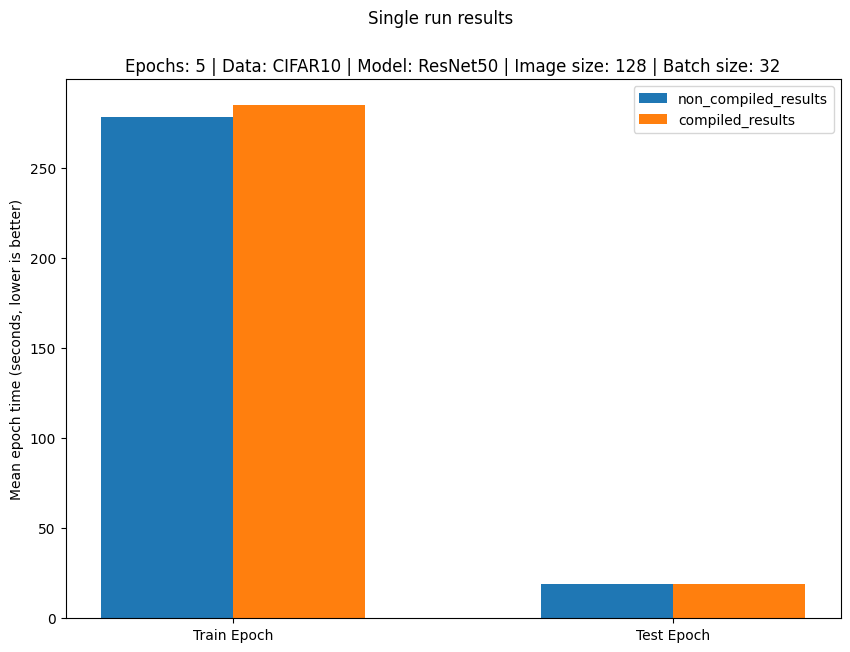

In [20]:
plot_mean_epoch_times(non_compiled_results=single_run_no_compile_results_df, 
                      compiled_results=single_run_compile_results_df, 
                      multi_runs=False, 
                      save=True,
                      save_path="epoch_times_comparison.png")

In [21]:
def create_and_train_non_compiled_model(epochs=NUM_EPOCHS, 
                                        learning_rate=LEARNING_RATE, 
                                        disable_progress_bar=False):
    """
    Create and train a non-compiled PyTorch model.
    """
    model, _ = create_model()
    model.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)

    results = train(model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    epochs=epochs,
                    device=device,
                    disable_progress_bar=disable_progress_bar)
    return results

def create_compiled_model():
    """
    Create a compiled PyTorch model and return it.
    """
    model, _ = create_model()
    model.to(device)
    
    compile_start_time = time.time()
    ### New in PyTorch 2.x ###
    compiled_model = torch.compile(model)
    ##########################
    compile_end_time = time.time()

    compile_time = compile_end_time - compile_start_time

    print(f"Time to compile: {compile_time} | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.")
    return compiled_model

def train_compiled_model(model=compiled_model, 
                         epochs=NUM_EPOCHS, 
                         learning_rate=LEARNING_RATE,
                         disable_progress_bar=False):
    """
    Train a compiled model and return the results.
    """
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(compiled_model.parameters(),
                                 lr=learning_rate)
    
    compile_results = train(model=model,
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            loss_fn=loss_fn,
                            optimizer=optimizer,
                            epochs=epochs,
                            device=device,
                            disable_progress_bar=disable_progress_bar)
    
    return compile_results

In [22]:
# Run non-compiled model for multiple runs
NUM_RUNS = 3
NUM_EPOCHS = 5

# Create an empty list to store multiple run results
non_compile_results_multiple_runs = []

# Run non-compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for non-compiled model")
    results = create_and_train_non_compiled_model(epochs=NUM_EPOCHS, disable_progress_bar=True)
    non_compile_results_multiple_runs.append(results)

  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.2556 | train_acc: 0.5457 | test_loss: 1.0357 | test_acc: 0.6371 | train_epoch_time: 275.4204 | test_epoch_time: 18.7562
Epoch: 2 | train_loss: 0.7797 | train_acc: 0.7268 | test_loss: 0.8390 | test_acc: 0.7165 | train_epoch_time: 275.3036 | test_epoch_time: 18.7747
Epoch: 3 | train_loss: 0.5707 | train_acc: 0.8007 | test_loss: 0.6054 | test_acc: 0.7900 | train_epoch_time: 275.1358 | test_epoch_time: 18.6967
Epoch: 4 | train_loss: 0.4467 | train_acc: 0.8454 | test_loss: 0.5556 | test_acc: 0.8143 | train_epoch_time: 275.3187 | test_epoch_time: 18.7088
Epoch: 5 | train_loss: 0.3449 | train_acc: 0.8795 | test_loss: 0.5036 | test_acc: 0.8281 | train_epoch_time: 275.7380 | test_epoch_time: 18.7181
[INFO] Run 2 of 3 for non-compiled model
Epoch: 1 | train_loss: 1.1722 | train_acc: 0.5774 | test_loss: 0.9447 | test_acc: 0.6719 | train_epoch_time: 276.4018 | test_epoch_time: 18.8533
Epoch: 2 | train_loss: 0.7235 | train_acc: 0.749

In [23]:
# Go through non_compile_results_multiple_runs and create a dataframe for each run then concatenate them together
non_compile_results_dfs = []
for result in non_compile_results_multiple_runs:
    result_df = pd.DataFrame(result)
    non_compile_results_dfs.append(result_df)
non_compile_results_multiple_runs_df = pd.concat(non_compile_results_dfs)

# Get the averages across the multiple runs
non_compile_results_multiple_runs_df = non_compile_results_multiple_runs_df.groupby(non_compile_results_multiple_runs_df.index).mean()
non_compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,1.211576,0.562947,1.018488,0.643470,275.621620,18.752528
1,0.755534,0.736278,0.730930,0.750100,275.509225,18.713391
2,0.555968,0.806702,0.596793,0.793697,275.447823,18.720411
3,0.434654,0.850121,0.527037,0.822750,275.555811,18.740115
4,0.333092,0.884510,0.487204,0.836096,275.651826,18.662506


In [24]:
# Create compiled model
compiled_model = create_compiled_model()

# Create an empty list to store compiled model results
compiled_results_multiple_runs = []

# Run compiled model for multiple runs
for i in tqdm(range(NUM_RUNS)):
    print(f"[INFO] Run {i+1} of {NUM_RUNS} for compiled model")
    # Train the compiled model (note: the model will only be compiled once and then re-used for subsequent runs)
    results = train_compiled_model(model=compiled_model, epochs=NUM_EPOCHS, disable_progress_bar=True)
    compiled_results_multiple_runs.append(results)

Time to compile: 0.0017609596252441406 | Note: The first time you compile your model, the first few epochs will be slower than subsequent runs.


  0%|          | 0/3 [00:00<?, ?it/s]

[INFO] Run 1 of 3 for compiled model
Epoch: 1 | train_loss: 1.1586 | train_acc: 0.5819 | test_loss: 0.9144 | test_acc: 0.6745 | train_epoch_time: 275.1540 | test_epoch_time: 18.8432
Epoch: 2 | train_loss: 0.7052 | train_acc: 0.7541 | test_loss: 0.7374 | test_acc: 0.7412 | train_epoch_time: 275.5065 | test_epoch_time: 18.8171
Epoch: 3 | train_loss: 0.5345 | train_acc: 0.8161 | test_loss: 0.5602 | test_acc: 0.8060 | train_epoch_time: 275.5504 | test_epoch_time: 18.6937
Epoch: 4 | train_loss: 0.4158 | train_acc: 0.8557 | test_loss: 0.4743 | test_acc: 0.8402 | train_epoch_time: 275.2414 | test_epoch_time: 18.7959
Epoch: 5 | train_loss: 0.3202 | train_acc: 0.8889 | test_loss: 0.4516 | test_acc: 0.8506 | train_epoch_time: 275.4432 | test_epoch_time: 18.7335
[INFO] Run 2 of 3 for compiled model
Epoch: 1 | train_loss: 0.2525 | train_acc: 0.9108 | test_loss: 0.4858 | test_acc: 0.8447 | train_epoch_time: 275.5786 | test_epoch_time: 18.6815
Epoch: 2 | train_loss: 0.1728 | train_acc: 0.9408 | test

In [25]:
# Go through compile_results_multiple_runs and create a dataframe for each run then concatenate them together
compile_results_dfs = []
for result in compiled_results_multiple_runs:
    result_df = pd.DataFrame(result)
    compile_results_dfs.append(result_df)
compile_results_multiple_runs_df = pd.concat(compile_results_dfs)

# Get the averages across the multiple runs
compile_results_multiple_runs_df = compile_results_multiple_runs_df.groupby(compile_results_multiple_runs_df.index).mean() # .index = groupby the epoch number
compile_results_multiple_runs_df

,train_loss,train_acc,test_loss,test_acc,train_epoch_time,test_epoch_time
0,0.495794,0.821870,0.652214,0.792399,275.523742,18.770048
1,0.314464,0.890962,0.566510,0.825146,275.861858,18.769439
2,0.236588,0.918646,0.533929,0.843251,275.689193,18.662356
3,0.187875,0.934828,0.496378,0.860091,275.500034,18.713465
4,0.148041,0.948723,0.521926,0.860057,275.659885,18.695021


Mean train epoch time difference: 0.033% (negative means faster)
Mean test epoch time difference: 0.023% (negative means faster)
[INFO] Plot saved to /kaggle/working/


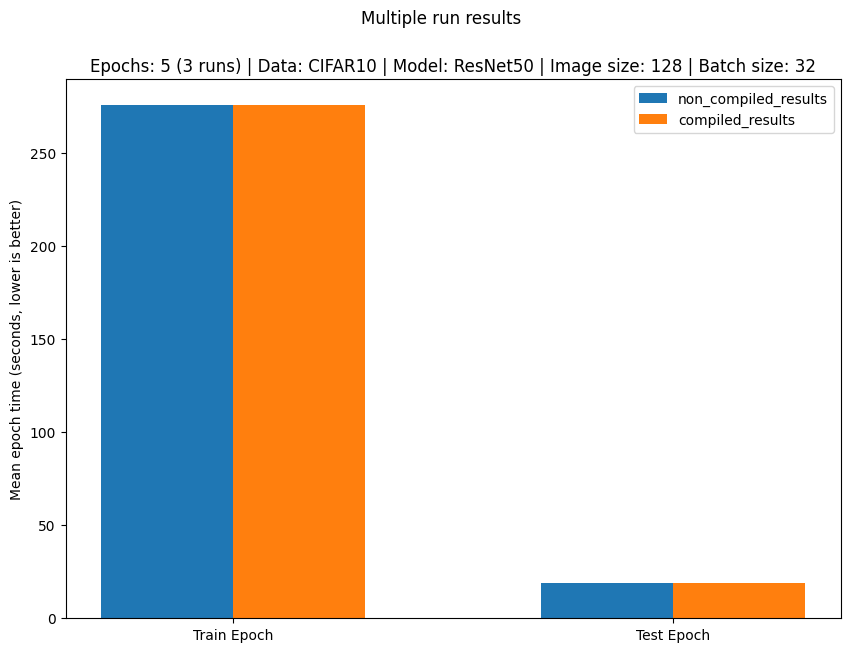

In [29]:
# Plot the mean epoch times for experiment 3 and 4
plot_mean_epoch_times(non_compiled_results=non_compile_results_multiple_runs_df, 
                      compiled_results=compile_results_multiple_runs_df, 
                      multi_runs=True, 
                      num_runs=NUM_RUNS, 
                      save=True,
                      save_path="/kaggle/working/")  # Specify your desired save path here
